/home/th/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-12 11:21:04.507587: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 11:21:04.519877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760242864.534406    3345 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760242864.539640    3345 cuda_blas.cc:1418] Un

1. Đang load và chuẩn bị dữ liệu...
Chuẩn bị dữ liệu hoàn tất.

Bắt đầu huấn luyện model 'AdvancedDimReducerAE'...
Epoch 10/100 | Train Loss: 0.033141 | Val Loss: 0.115012
Early stopping được kích hoạt tại epoch 17.
Huấn luyện hoàn tất trong 102.97 giây. Model tốt nhất đã lưu vào 'best_dim_reducer_ae.pth'.

Bắt đầu huấn luyện model 'RobustAnomalyAE'...
Epoch 10/150 | Train Loss: 0.178960 | Val Loss: 0.107314
Epoch 20/150 | Train Loss: 0.156335 | Val Loss: 0.060710
Epoch 30/150 | Train Loss: 0.145898 | Val Loss: 0.048153
Epoch 40/150 | Train Loss: 0.141280 | Val Loss: 0.052968
Epoch 50/150 | Train Loss: 0.138753 | Val Loss: 0.054447
Epoch 60/150 | Train Loss: 0.137911 | Val Loss: 0.049942
Epoch 70/150 | Train Loss: 0.137293 | Val Loss: 0.045775
Epoch 80/150 | Train Loss: 0.137211 | Val Loss: 0.067746
Epoch 90/150 | Train Loss: 0.137514 | Val Loss: 0.050825
Epoch 100/150 | Train Loss: 0.135749 | Val Loss: 0.049295
Early stopping được kích hoạt tại epoch 103.
Huấn luyện hoàn tất trong 603

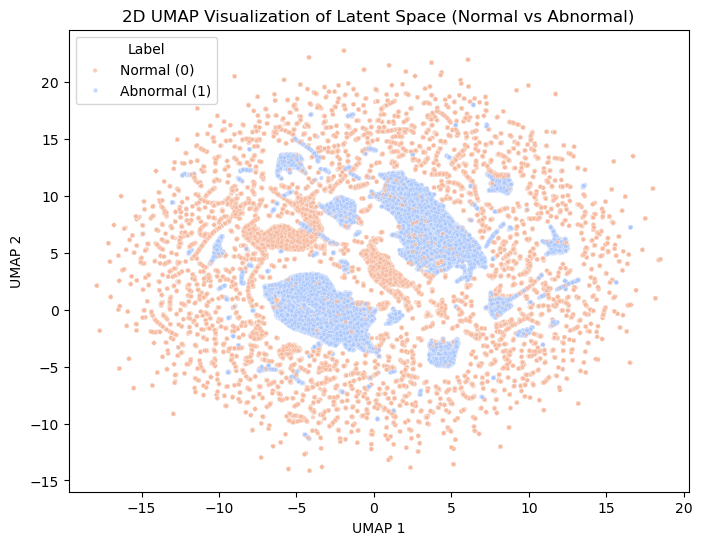

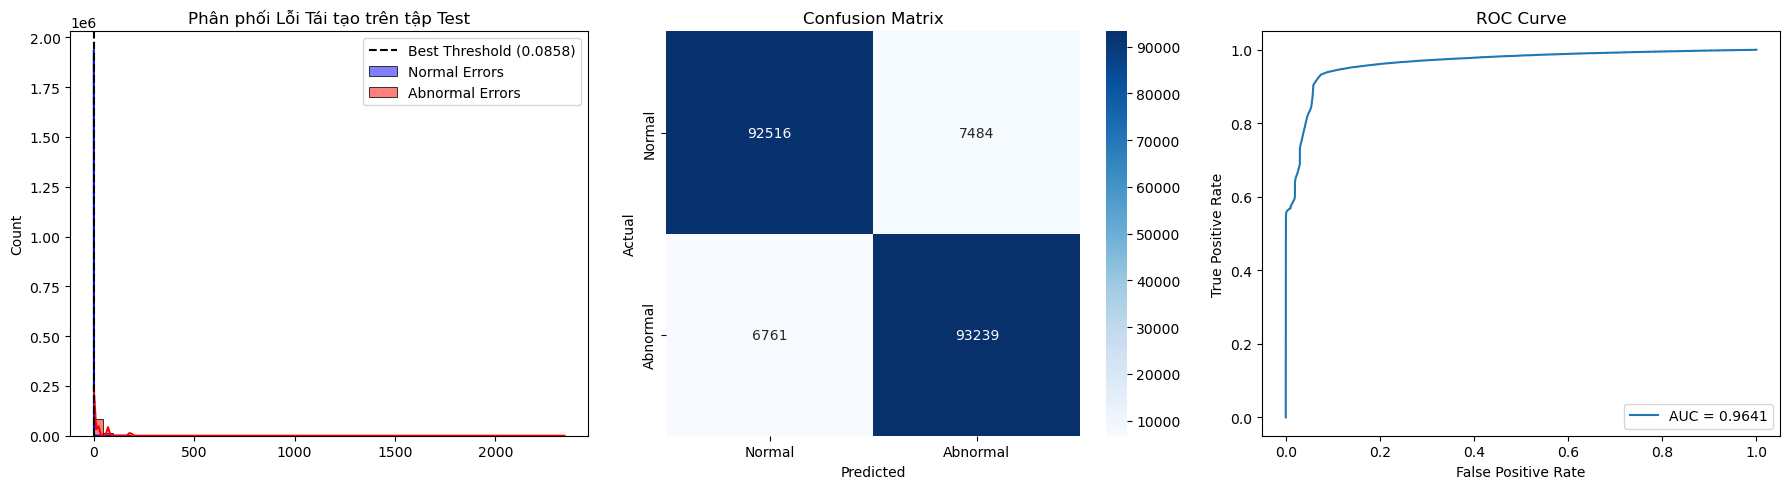

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import umap
import time
import warnings
warnings.filterwarnings('ignore')

# ===================================================================
# HÀM HUẤN LUYỆN ĐÃ SỬA LỖI
# ===================================================================
def train_model(model, train_loader, val_loader, epochs, patience, learning_rate, weight_decay, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    print(f"Bắt đầu huấn luyện model '{model.__class__.__name__}'...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            # === SỬA LỖI TẠI ĐÂY ===
            # Xử lý linh hoạt output của model
            output = model(data)
            if isinstance(output, tuple):
                reconstructed = output[0]
            else:
                reconstructed = output
            # ========================

            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for (data,) in val_loader:
                data = data.to(device)
                
                # === SỬA LỖI TẠI ĐÂY (CHO VALIDATION) ===
                output = model(data)
                if isinstance(output, tuple):
                    reconstructed = output[0]
                else:
                    reconstructed = output
                # ======================================

                loss = criterion(reconstructed, data)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping được kích hoạt tại epoch {epoch+1}.")
            break
            
    end_time = time.time()
    print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây. Model tốt nhất đã lưu vào '{model_save_path}'.\n")
    model.load_state_dict(torch.load(model_save_path))
    return model

# ============================
# 1. Load và chuẩn bị dữ liệu
# ============================
print("1. Đang load và chuẩn bị dữ liệu...")
try:
    train_data_raw = pd.read_csv('unsupervised_dataset.csv')
    test_data_raw = pd.read_csv('evaluation_dataset.csv')
    
    X_train = train_data_raw.apply(pd.to_numeric, errors='coerce').fillna(0).values
    X_test = test_data_raw.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_test = test_data_raw.iloc[:, -1].values
    y_test_binary = np.where(y_test == -1, 1, 0)
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    exit()

X_train_split, X_val_split = train_test_split(X_train, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
BATCH_SIZE = 512
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=BATCH_SIZE, shuffle=False)
print("Chuẩn bị dữ liệu hoàn tất.\n")

# ============================
# 2. AutoEncoder giảm chiều (Nâng cao)
# ============================
class AdvancedDimReducerAE(nn.Module):
    def __init__(self, input_dim=X_train.shape[1], latent_dim=16):
        super(AdvancedDimReducerAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Linear(32, 64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

dim_reducer_ae = AdvancedDimReducerAE()
# Thêm một chút weight_decay cho model đầu tiên để giúp ổn định
dim_reducer_ae = train_model(dim_reducer_ae, train_loader, val_loader, epochs=100, patience=15, learning_rate=1e-3, weight_decay=1e-5, model_save_path="best_dim_reducer_ae.pth")

dim_reducer_ae.eval()
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    _, latent_train = dim_reducer_ae(X_train_tensor.to(device))
    _, latent_val = dim_reducer_ae(X_val_tensor.to(device))
    _, latent_test = dim_reducer_ae(X_test_tensor.to(device))

latent_scaler = StandardScaler()
X_train_latent_scaled = latent_scaler.fit_transform(latent_train.cpu().numpy())
X_val_latent_scaled = latent_scaler.transform(latent_val.cpu().numpy())
X_test_latent_scaled = latent_scaler.transform(latent_test.cpu().numpy())
X_train_latent_tensor = torch.FloatTensor(X_train_latent_scaled)
X_val_latent_tensor = torch.FloatTensor(X_val_latent_scaled)
X_test_latent_tensor = torch.FloatTensor(X_test_latent_scaled)
train_latent_loader = DataLoader(TensorDataset(X_train_latent_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_latent_loader = DataLoader(TensorDataset(X_val_latent_tensor), batch_size=BATCH_SIZE, shuffle=False)

# ============================
# 3. AutoEncoder phát hiện bất thường (Mạnh mẽ hơn)
# ============================
class RobustAnomalyAE(nn.Module):
    def __init__(self, input_dim=16, latent_dim=8):
        super(RobustAnomalyAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48), nn.BatchNorm1d(48), nn.LeakyReLU(0.1), nn.Dropout(0.3),
            nn.Linear(48, 24), nn.BatchNorm1d(24), nn.LeakyReLU(0.1),
            nn.Linear(24, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 24), nn.BatchNorm1d(24), nn.LeakyReLU(0.1),
            nn.Linear(24, 48), nn.BatchNorm1d(48), nn.LeakyReLU(0.1), nn.Dropout(0.3),
            nn.Linear(48, input_dim)
        )
    # LƯU Ý: forward này chỉ trả về 1 giá trị
    def forward(self, x):
        return self.decoder(self.encoder(x))

anomaly_ae = RobustAnomalyAE()
anomaly_ae = train_model(anomaly_ae, train_latent_loader, val_latent_loader, epochs=150, patience=20, learning_rate=1e-4, weight_decay=1e-5, model_save_path="best_anomaly_ae_robust.pth")

# ============================
# 4. Đánh giá mô hình và tìm ngưỡng tối ưu
# ============================
print("4. Đánh giá và tìm ngưỡng tối ưu...")
anomaly_ae.eval()
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reconstructed_test = anomaly_ae(X_test_latent_tensor.to(device))
    test_errors = torch.mean((X_test_latent_tensor.to(device) - reconstructed_test)**2, dim=1).cpu().numpy()

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_binary, test_errors)
f1_scores = 2 * (precision_curve[:-1] * recall_curve[:-1]) / (precision_curve[:-1] + recall_curve[:-1] + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = threshold_curve[best_threshold_idx]

y_pred_binary = (test_errors > best_threshold).astype(int)

auc = roc_auc_score(y_test_binary, test_errors)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')

print(f"\n=== KẾT QUẢ ĐÁNH GIÁ (TỐI ƯU HÓA TOÀN DIỆN) ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Threshold tối ưu (từ F1-max): {best_threshold:.6f}\n")

# ============================
# 5. Trực quan hóa
# ============================
print("5. Vẽ biểu đồ trực quan hóa...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
latent_test_2d = reducer.fit_transform(X_test_latent_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_test_2d[:, 0], y=latent_test_2d[:, 1], hue=y_test_binary, palette='coolwarm', s=10, alpha=0.7)
plt.title('2D UMAP Visualization of Latent Space (Normal vs Abnormal)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label', labels=['Normal (0)', 'Abnormal (1)'])
plt.savefig('umap_latent_space_final_viz.png')
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(test_errors[y_test_binary==0], bins=50, kde=True, color='blue', label='Normal Errors')
sns.histplot(test_errors[y_test_binary==1], bins=50, kde=True, color='red', label='Abnormal Errors')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Threshold ({best_threshold:.4f})')
plt.title('Phân phối Lỗi Tái tạo trên tập Test')
plt.legend()
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test_binary, test_errors)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig("final_evaluation_charts_optimized.png")
plt.show()